[View in Colaboratory](https://colab.research.google.com/github/lbrandt123/R-Data-Science/blob/master/Representation.ipynb)

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Feature Sets

**Learning Objective:** Create a minimal set of features that performs just as well as a more complex feature set

So far, we've thrown all of our features into the model. Models with fewer features use fewer resources and are easier to maintain. Let's see if we can build a model on a minimal set of housing features that will perform equally as well as one that uses all the features in the data set.

## Setup

As before, let's load and prepare the California housing data.

In [0]:
# IMPORT REQUIRED LIBRARIES
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

# SET UP LOGGING AND DISPLAY OPTIONS
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

# LOAD THE DATASET
california_housing_dataframe = pd.read_csv("https://dl.google.com/mlcc/mledu-datasets/california_housing_train.csv", sep=",")

# RANDOMIZE THE DATA
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index)) 

In [0]:
# DEFINE A FUNCTION TO PREPROCESS THE FEATURES
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # CREATE A SYNTHETIC FEATURE
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

# DEFINE A FUNCTION TO PREPROCESS TARGETS
def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # SCALE THE TARGET: units of thousands of dollars
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [4]:
# SELECT THE TRAINING SET: Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# SELECT THE VALIDATION SET: Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# EXAMINE THE DATA: Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.7,2623.7,535.4,1421.8,497.2,3.9,2.0
std,2.1,2.0,12.6,2192.2,421.0,1166.6,384.1,1.9,1.2
min,32.5,-124.3,1.0,2.0,2.0,3.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1453.0,295.0,784.0,279.0,2.6,1.5
50%,34.2,-118.5,29.0,2110.0,430.0,1160.0,406.0,3.5,1.9
75%,37.7,-118.0,37.0,3113.2,644.0,1710.0,599.0,4.7,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,35682.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.5,28.3,2691.5,549.1,1448.3,510.8,3.9,2.0
std,2.1,2.0,12.4,2149.7,422.5,1101.4,385.4,1.9,1.0
min,32.6,-124.3,2.0,8.0,1.0,8.0,1.0,0.5,0.1
25%,33.9,-121.7,18.0,1481.8,303.0,805.0,287.0,2.6,1.5
50%,34.2,-118.5,28.0,2174.5,445.0,1183.0,417.0,3.6,2.0
75%,37.7,-118.0,37.0,3224.2,661.0,1763.0,615.2,4.8,2.3
max,42.0,-114.5,52.0,30401.0,4957.0,13251.0,4339.0,15.0,34.2


Training targets summary:


,median_house_value
count,12000.0
mean,206.9
std,115.6
min,15.0
25%,120.1
50%,179.6
75%,263.8
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,208.3
std,116.9
min,25.0
25%,118.5
50%,181.9
75%,266.9
max,500.0


## Task 1: Develop a Good Feature Set

**What's the best performance you can get with just 2 or 3 features?**

A **correlation matrix** shows pairwise correlations, both for each feature compared to the target and for each feature compared to other features.

Here, correlation is defined as the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient).  You don't have to understand the mathematical details for this exercise.

Correlation values have the following meanings:

  * `-1.0`: perfect negative correlation
  * `0.0`: no correlation
  * `1.0`: perfect positive correlation

In [5]:
# DISPLAY A CORRELATION MATRIX
correlation_dataframe = training_examples.copy()
correlation_dataframe["target"] = training_targets["median_house_value"]

correlation_dataframe.corr()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person,target
latitude,1.0,-0.9,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,0.1,-0.1
longitude,-0.9,1.0,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.1,-0.0
housing_median_age,0.0,-0.1,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,-0.1,0.1
total_rooms,-0.0,0.0,-0.4,1.0,0.9,0.9,0.9,0.2,0.1,0.1
total_bedrooms,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.0,0.0
population,-0.1,0.1,-0.3,0.9,0.9,1.0,0.9,0.0,-0.1,-0.0
households,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,0.0,-0.0,0.1
median_income,-0.1,-0.0,-0.1,0.2,-0.0,0.0,0.0,1.0,0.2,0.7
rooms_per_person,0.1,-0.1,-0.1,0.1,0.0,-0.1,-0.0,0.2,1.0,0.2
target,-0.1,-0.0,0.1,0.1,0.0,-0.0,0.1,0.7,0.2,1.0


Features that have strong positive or negative correlations with the target will add information to our model. We can use the correlation matrix to find such strongly correlated features.

We'd also like to have features that aren't so strongly correlated with each other, so that they add independent information.

Use this information to try removing features.  You can also try developing additional synthetic features, such as ratios of two raw features.

For convenience, we've included the training code from the previous exercise.

In [0]:
# DEFINE A FUNCTION TO CONSTRUCT THE FEATURE COLUMNS
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
# DEFINE A FUNCTION TO TRAIN THE LINEAR REGRESSION MODEL
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # CONVERT PANDAS DATA INTO A DICT OF NP ARRAYS
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
    
    # CONSTRUCT A DATASET, CONFIGURE BATCHING/REPEATING
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)

    # SHUFFLE THE DATA: if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # RETURN THE NEXT BATCH OF DATA
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
# DEFINE A FUNCTION TO TRAIN THE LINEAR REGRESSION MODEL
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods

  # CREATE A LINEAR REGRESSOR OBJECT
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
    
  # CREATE INPUT FUNCTIONS
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # TRAIN THE MODEL INSIDE A LOOP (so that we can periodically assess loss metrics)
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # TRAIN THE MODEL, STARTING FROM THE PRIOR STATE
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # COMPUTE PREDICTIONS
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # COMPUTE TRAINING AND VALIDATION LOSS
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # OCCASIONALLY PRINT THE CURRENT LOSS
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # ADD LOSS METRICS FROM THIS PERIOD TO LIST
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  
  # OUTPUT GRAPY: loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Spend 5 minutes searching for a good set of features and training parameters. Then check the solution to see what we chose. Don't forget that different features may require different learning parameters.

Training model...
RMSE (on training data):
  period 00 : 225.82
  period 01 : 214.72
  period 02 : 203.73
  period 03 : 192.87
  period 04 : 182.17
  period 05 : 171.64
  period 06 : 161.32
  period 07 : 151.28
  period 08 : 141.52
  period 09 : 132.35
Model training finished.


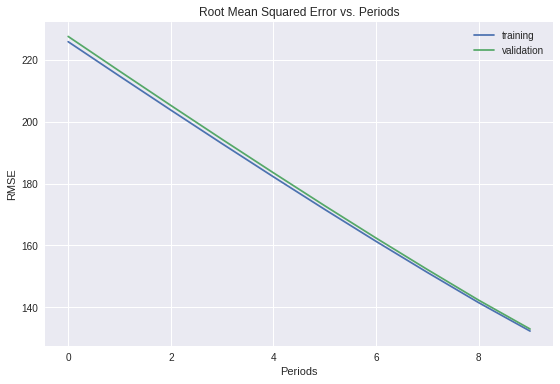

In [9]:
#
# Your code here: add your features of choice as a list of quoted strings.
#
minimal_features = ["median_income", "rooms_per_person"
]

assert minimal_features, "You must select at least one feature!"

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

#
# Don't forget to adjust these parameters.
#
train_model(
    learning_rate=0.01,
    steps=500,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

I cas see from the graph that this is nowhere near the minimal value (there is no curve to the line), so I am increasing the learning rate by a factor of ten (from 0.001 to 0.01) 

Training model...
RMSE (on training data):
  period 00 : 222.48
  period 01 : 208.14
  period 02 : 194.02
  period 03 : 180.13
  period 04 : 166.56
  period 05 : 153.39
  period 06 : 140.82
  period 07 : 128.76
  period 08 : 117.89
  period 09 : 108.43
Model training finished.


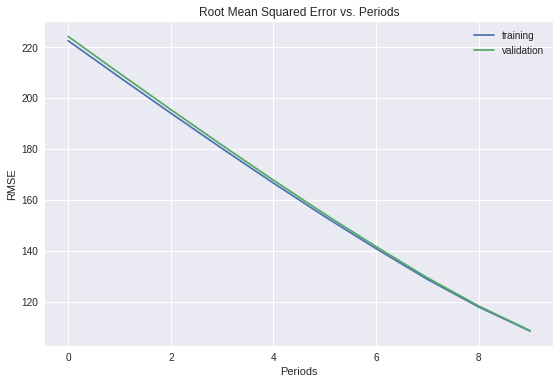

In [10]:
train_model(
    learning_rate=0.01,
    steps=650,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

Increasing the number of steps....

Training model...
RMSE (on training data):
  period 00 : 220.27
  period 01 : 203.76
  period 02 : 187.53
  period 03 : 171.74
  period 04 : 156.34
  period 05 : 141.58
  period 06 : 127.71
  period 07 : 114.98
  period 08 : 104.61
  period 09 : 96.65
Model training finished.


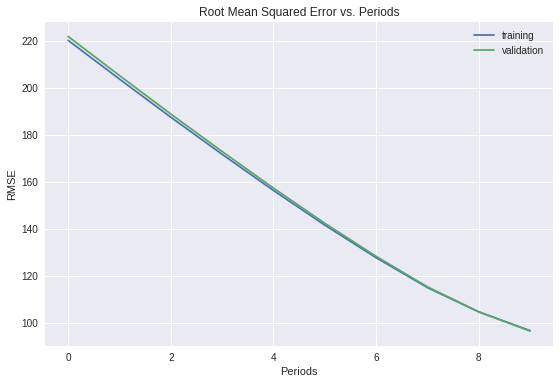

In [11]:
train_model(
    learning_rate=0.01,
    steps=750,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

Increasing the number of steps....

Training model...
RMSE (on training data):
  period 00 : 218.15
  period 01 : 199.50
  period 02 : 181.23
  period 03 : 163.47
  period 04 : 146.73
  period 05 : 130.99
  period 06 : 116.80
  period 07 : 104.48
  period 08 : 96.37
  period 09 : 90.37
Model training finished.


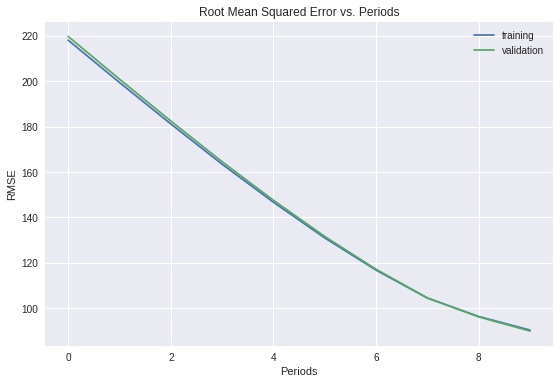

In [12]:
train_model(
    learning_rate=0.01,
    steps=850,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

Increasing the number of steps....

Training model...
RMSE (on training data):
  period 00 : 216.98
  period 01 : 197.25
  period 02 : 178.08
  period 03 : 159.42
  period 04 : 141.92
  period 05 : 125.32
  period 06 : 110.50
  period 07 : 99.58
  period 08 : 93.02
  period 09 : 89.42
Model training finished.


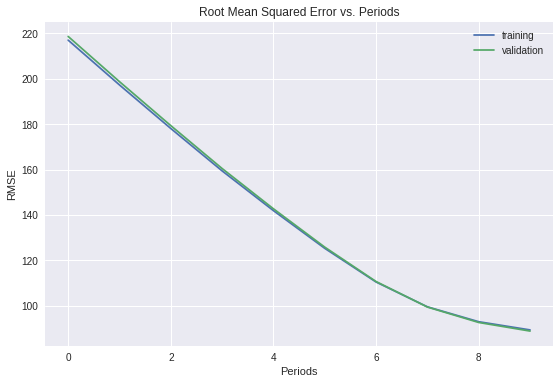

In [13]:
train_model(
    learning_rate=0.01,
    steps=900,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

Increasing the number of steps....

Training model...
RMSE (on training data):
  period 00 : 214.77
  period 01 : 192.93
  period 02 : 171.70
  period 03 : 151.30
  period 04 : 132.31
  period 05 : 115.10
  period 06 : 101.68
  period 07 : 93.22
  period 08 : 89.69
  period 09 : 87.03
Model training finished.


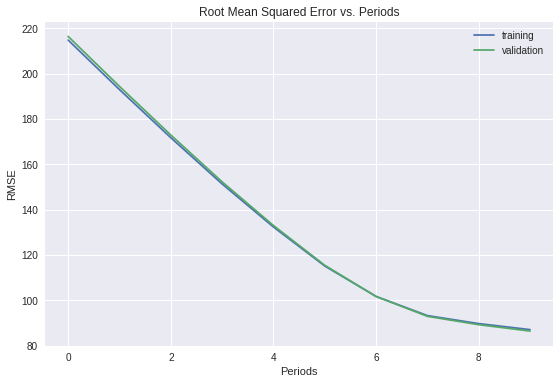

In [14]:
train_model(
    learning_rate=0.01,
    steps=1000,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

This is very close to bottoming-out. 

Training model...
RMSE (on training data):
  period 00 : 212.52
  period 01 : 188.73
  period 02 : 165.57
  period 03 : 143.59
  period 04 : 123.64
  period 05 : 107.02
  period 06 : 96.01
  period 07 : 89.77
  period 08 : 86.70
  period 09 : 85.62
Model training finished.


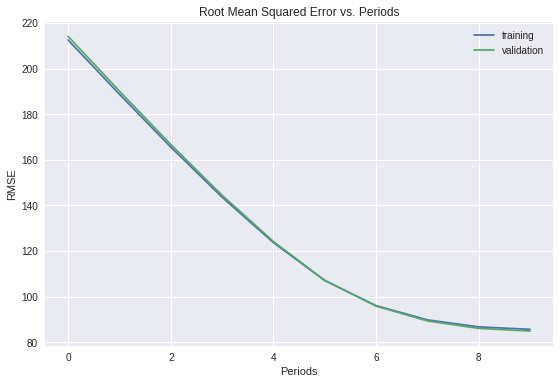

In [15]:
train_model(
    learning_rate=0.01,
    steps=1100,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

What if I increase the learning rate just a smidge (from 0.01 to 0.8)?

Training model...
RMSE (on training data):
  period 00 : 86.90
  period 01 : 85.35
  period 02 : 85.01
  period 03 : 91.17
  period 04 : 84.23
  period 05 : 84.62
  period 06 : 87.57
  period 07 : 83.76
  period 08 : 83.67
  period 09 : 83.67
Model training finished.


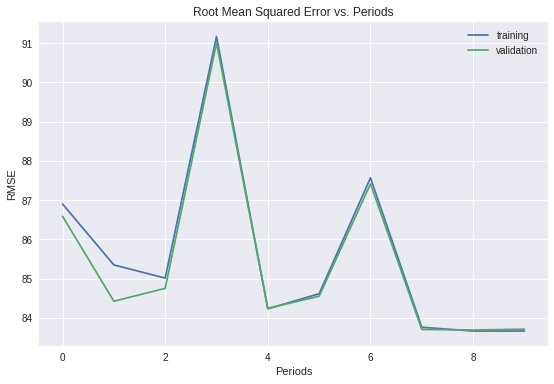

In [16]:
train_model(
    learning_rate=0.8,
    steps=1000,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

Whoa!! Too much. It's jumping back and forth over the minimum value. Let me adjust my parameters (learning rate goes to 0.015, number of steps is 1000).

Training model...
RMSE (on training data):
  period 00 : 203.83
  period 01 : 171.74
  period 02 : 141.83
  period 03 : 115.38
  period 04 : 96.43
  period 05 : 88.48
  period 06 : 86.12
  period 07 : 85.58
  period 08 : 85.34
  period 09 : 85.28
Model training finished.


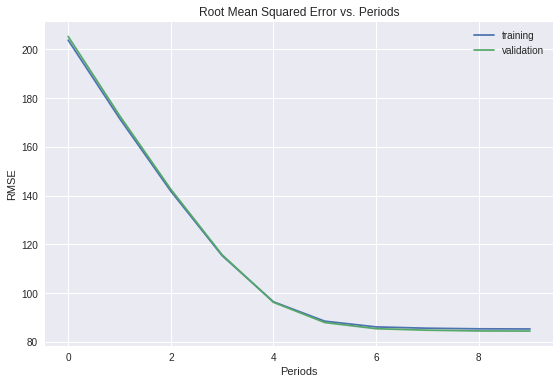

In [17]:
train_model(
    learning_rate=0.015,
    steps=1000,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

I also want to try adjusting the learning rate some more to see what happens (from 0.015 to 0.03).

Training model...
RMSE (on training data):
  period 00 : 171.68
  period 01 : 115.32
  period 02 : 87.27
  period 03 : 85.38
  period 04 : 85.29
  period 05 : 85.03
  period 06 : 85.09
  period 07 : 85.09
  period 08 : 85.06
  period 09 : 84.93
Model training finished.


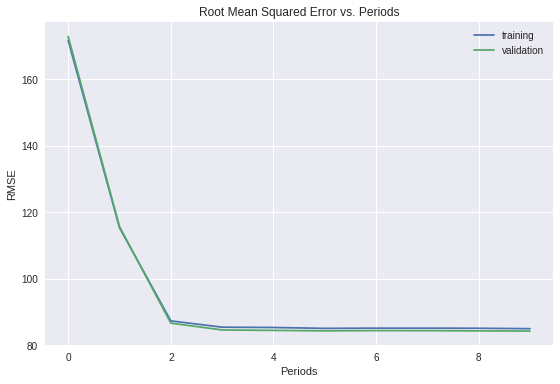

In [18]:
train_model(
    learning_rate=0.03,
    steps=1000,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

I can see that it is bouncing back and forth beyond the minimum. However, what interests me is that the first value of RMSE in period 0 is the same as the value in period 1 when the learning rate was half of this value! I am going to try increasing the learning rate by 50% (from 0.03 to 0.45) and see if that corresponds the the value in period 3 when the learning rate was 0.015.

Training model...
RMSE (on training data):
  period 00 : 141.57
  period 01 : 87.62
  period 02 : 85.21
  period 03 : 85.74
  period 04 : 84.78
  period 05 : 84.75
  period 06 : 84.77
  period 07 : 85.08
  period 08 : 84.77
  period 09 : 85.10
Model training finished.


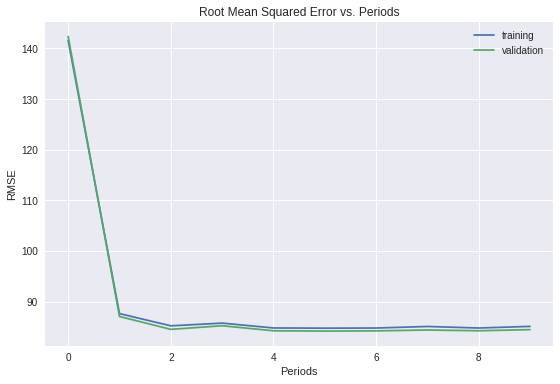

In [19]:
train_model(
    learning_rate=0.045,
    steps=1000,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

Wow! It was ~equal to the value of the second period with a learning rate 1/3 this value! And look how quickly it fell to the (roughly) minimum value! 

I wonder what would happen if I go back to a learning rate of 0.015, but double the number of steps (to 2000)? My guess is that it will more quickly converge (and probably go beyond the minimum).

Training model...
RMSE (on training data):
  period 00 : 171.65
  period 01 : 115.92
  period 02 : 89.12
  period 03 : 85.30
  period 04 : 85.22
  period 05 : 85.11
  period 06 : 85.06
  period 07 : 85.07
  period 08 : 84.85
  period 09 : 84.83
Model training finished.


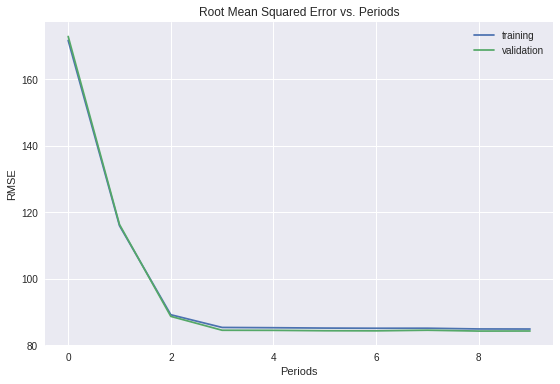

In [20]:
train_model(
    learning_rate=0.015,
    steps=2000,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

Well, the best RMSE was 85.23 -- much better than the 180 we were shooting for! I wonder if it would improve by adding in any other features. Looking at the correlation matrix, latitude has a correlation of -0.2 to the median house value. Let me try adding that in.

Training model...
RMSE (on training data):
  period 00 : 116.66
  period 01 : 114.46
  period 02 : 114.46
  period 03 : 112.06
  period 04 : 110.25
  period 05 : 108.11
  period 06 : 106.38
  period 07 : 106.07
  period 08 : 103.04
  period 09 : 101.86
Model training finished.


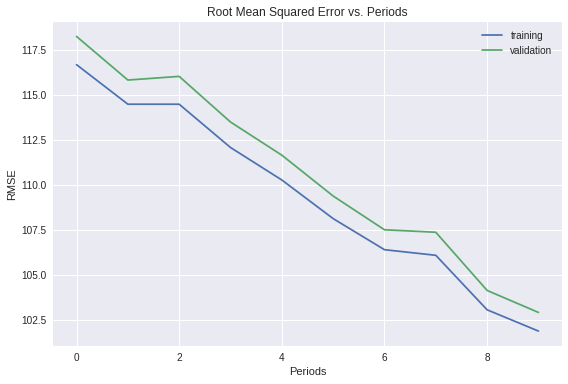

In [21]:
#
# Your code here: add your features of choice as a list of quoted strings.
#
minimal_features = ["median_income", "rooms_per_person", "latitude"
]

assert minimal_features, "You must select at least one feature!"

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

#
# Don't forget to adjust these parameters.
#
train_model(
    learning_rate=0.015,
    steps=1000,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)


That is a very strange-looking line for RMSE!!! I guess that adding in a feature with a negative correlation can create those intermediate peaks. But, it doesn't look as though we have reached our minimum value yet, so let me adjust the training steps to 1250 and see what happens.


Training model...
RMSE (on training data):
  period 00 : 115.90
  period 01 : 114.26
  period 02 : 111.92
  period 03 : 110.15
  period 04 : 108.82
  period 05 : 106.13
  period 06 : 104.85
  period 07 : 103.15
  period 08 : 101.69
  period 09 : 100.49
Model training finished.


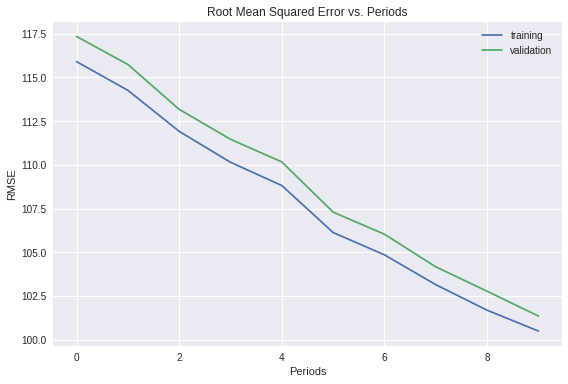

In [22]:
train_model(
    learning_rate=0.015,
    steps=1250,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

### Solution

Click below for a solution.

That's not going to get to the minimum, so let me adjust the number of steps to 2000.

Training model...
RMSE (on training data):
  period 00 : 115.11
  period 01 : 112.04
  period 02 : 108.77
  period 03 : 105.62
  period 04 : 103.58
  period 05 : 100.13
  period 06 : 98.83
  period 07 : 96.56
  period 08 : 94.19
  period 09 : 92.76
Model training finished.


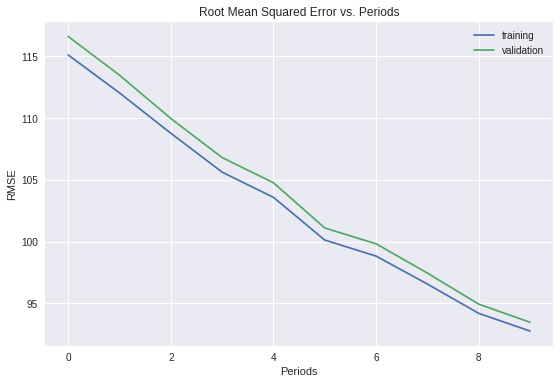

In [23]:
train_model(
    learning_rate=0.015,
    steps=2000,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

Still not what I am looking for. I am going to increase the learning rate to 0.02 and put the number of steps back to 1000 to see what happens.

Training model...
RMSE (on training data):
  period 00 : 115.75
  period 01 : 115.87
  period 02 : 112.02
  period 03 : 111.14
  period 04 : 108.70
  period 05 : 106.43
  period 06 : 104.75
  period 07 : 105.23
  period 08 : 101.46
  period 09 : 99.90
Model training finished.


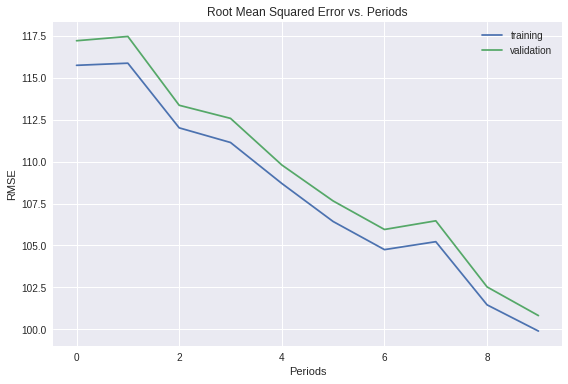

In [24]:
train_model(
    learning_rate=0.02,
    steps=1000,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

Nope, still not what I am looking for... I want to achieve an RMSE lower than I was able to achieve without the third feature. I am going to increase the number of steps to 2000.

Training model...
RMSE (on training data):
  period 00 : 114.28
  period 01 : 110.14
  period 02 : 108.15
  period 03 : 103.69
  period 04 : 100.35
  period 05 : 97.45
  period 06 : 95.66
  period 07 : 95.50
  period 08 : 90.64
  period 09 : 89.50
Model training finished.


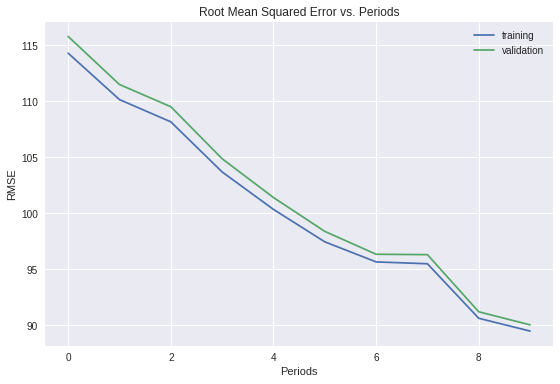

In [25]:
train_model(
    learning_rate=0.02,
    steps=2000,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

Wow. Still not reaching the minimum. Let me increase the learning rate to 0.025 and keep the number of steps at 2000.

Training model...
RMSE (on training data):
  period 00 : 112.73
  period 01 : 108.44
  period 02 : 103.27
  period 03 : 100.42
  period 04 : 96.18
  period 05 : 94.83
  period 06 : 93.29
  period 07 : 89.55
  period 08 : 92.46
  period 09 : 88.05
Model training finished.


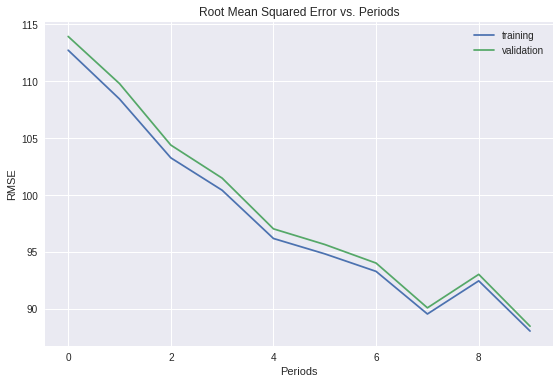

In [26]:
train_model(
    learning_rate=0.025,
    steps=2000,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

It seems to me that adding in latitude as a feature has actually hindered the analysis. 

## Task 2: Make Better Use of Latitude

Plotting `latitude` vs. `median_house_value` shows that there really isn't a linear relationship there.

Instead, there are a couple of peaks, which roughly correspond to Los Angeles and San Francisco.

Training model...
RMSE (on training data):
  period 00 : 165.05
  period 01 : 127.80
  period 02 : 116.46
  period 03 : 115.61
  period 04 : 115.10
  period 05 : 114.51
  period 06 : 114.25
  period 07 : 113.35
  period 08 : 112.71
  period 09 : 112.42
Model training finished.


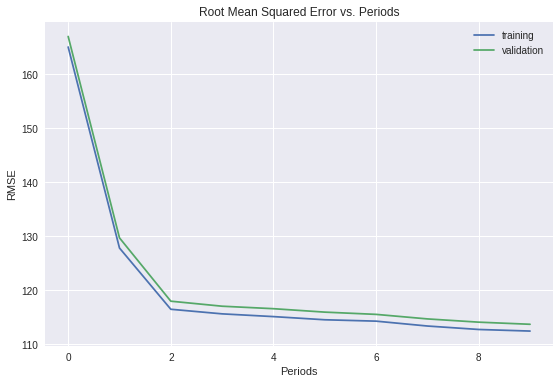

In [38]:
minimal_features = [
  "median_income",
  "latitude",
]

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

_ = train_model(
    learning_rate=0.01,
    steps=500,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

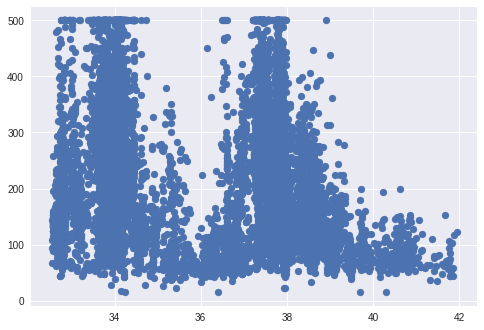

In [40]:
plt.scatter(training_examples["latitude"], training_targets["median_house_value"])

**Try creating some synthetic features that do a better job with latitude.**

For example, you could have a feature that maps `latitude` to a value of `|latitude - 38|`, and call this `distance_from_san_francisco`.

Or you could break the space into 10 different buckets.  `latitude_32_to_33`, `latitude_33_to_34`, etc., each showing a value of `1.0` if `latitude` is within that bucket range and a value of `0.0` otherwise.

Use the correlation matrix to help guide development, and then add them to your model if you find something that looks good.

What's the best validation performance you can get?

In [0]:
#
# YOUR CODE HERE: Train on a new data set that includes synthetic features based on latitude.
#

In [31]:
PRACTICE =  zip(range(32, 44), range(33,45)) # CREATES A DICT WHICH MAPS 32 TO 33
# AND MAPS 44 TO 45
PRACTICE

[(32, 33),
 (33, 34),
 (34, 35),
 (35, 36),
 (36, 37),
 (37, 38),
 (38, 39),
 (39, 40),
 (40, 41),
 (41, 42),
 (42, 43),
 (43, 44)]

In [0]:
PRACTICE_1 = zip(range(32, 44), range(33, 45)) # THIS CREATES A DICT 
# WHICH MAPS 32 TO 33 AND MAPS 44 TO 45.

# DEFINE A FUNCTION WHICH CREATES A FEATURE VECTOR FOR LATITUDE AND ASSIGNS 
# A 1 FOR LATITUDES BETWEEN 32 AND 33 DEGREES AND BETWEEN 44 AND 45 DEGREES.
# IT ASSIGNS A 0 FOR ALL OTHER LATITUDES. 
def select_and_transform_features(source_df):
  selected_examples = pd.DataFrame()
  selected_examples["median_income"] = source_df["median_income"]
  for r in PRACTICE_1:
    selected_examples["latitude_%d_to_%d" % r] = source_df["latitude"].apply(
      lambda l: 1.0 if l >= r[0] and l < r[1] else 0.0) """ THIS ASSIGNS A 
      VALUE OF 1 TO LATITUDES BETWEEN 32 AND 33 AND BETWEEN 44 AND 45.
      ALL OTHER LATITUDES ARE ASSIGNED A VALUE OF 0."""
  return selected_examples

selected_training_examples = select_and_transform_features(training_examples)
selected_validation_examples = select_and_transform_features(validation_examples)

Ah, I have a dict with values (for latitude) in one degree increments, beginning at 32 and ending at 44. This will mean that I would assign a value of 1 to any house between San Francisco and Los Angeles. But, all of those houses are not equally valuable! 

Looking at the scatterplot of median house value vs latitude, it seems to me that the most valuable housing is between latitude 33.5 and 34.5 and also between latitude 37 and 38.5. So, let me create another dict which will be split into half-degree increments.

In [44]:
PRACTICE_2 =  zip(range(64, 88), range(66,90)) # CREATES A DICT 
# WHICH IS TWICE THE ORIGINAL VALUES
PRACTICE_2

[(64, 66),
 (65, 67),
 (66, 68),
 (67, 69),
 (68, 70),
 (69, 71),
 (70, 72),
 (71, 73),
 (72, 74),
 (73, 75),
 (74, 76),
 (75, 77),
 (76, 78),
 (77, 79),
 (78, 80),
 (79, 81),
 (80, 82),
 (81, 83),
 (82, 84),
 (83, 85),
 (84, 86),
 (85, 87),
 (86, 88),
 (87, 89)]

Well, that didn't work. I need integer values for the range.

In [47]:
selected_examples = pd.DataFrame()
for r in PRACTICE_2:
    selected_examples["latitude_%d_to_%d" % r] = minimal_features["latitude"].apply(
      lambda l: 1.0 if l >= r[0] and l < r[1] else 0.0)
selected_examples

TypeError: ignored

I think I want to use the zip function. I want a dict with the first value being the latitude and the second value being a Boolean: 
1 if ((33.5 < latitude) and (34.5 < latitude)) or ((37 < latitude) and (38.5 < latitude))
0 for all other values of latitude

In [68]:
# PRACTICE_3
LAT = [36,37,39,35,38.5,32,38,31]
BOOL = []
#print("Length of LAT: ", len(LAT))
for i in range(0,len(LAT),1):
  if (37 <= LAT[i]):
    BOOL.append(1)
  else:
    BOOL.append(0)
fancy = list(zip(LAT,BOOL))
fancy

[(36, 0), (37, 1), (39, 1), (35, 0), (38.5, 1), (32, 0), (38, 1), (31, 0)]

OK!!! I have generated a list with two terms: the first term represents latitude and the second term is 1 if the latitude meets some criteria. 

In [77]:
# PRACTICE_4: Set the criteria for a house in the L.A. area (37<=latitude<=38.5)
LAT = [36,37,39,35,38.5,32,39.5,31]
BOOL = []
#print("Length of LAT: ", len(LAT))
for i in range(0,len(LAT),1):
  if (37 <= LAT[i] and (38.5<=LAT[i])):
    BOOL.append(1)
  else:
    BOOL.append(0)
fancy = list(zip(LAT,BOOL))
for i in range(0, len(fancy),1):
  if(BOOL[i]==1):  
    print(fancy[i])
list(fancy)

(39, 1)
(38.5, 1)
(39.5, 1)


[(36, 0), (37, 0), (39, 1), (35, 0), (38.5, 1), (32, 0), (39.5, 1), (31, 0)]

Okay! That worked Now I want to add the criteria for a house in the San Francisco area (33.5<=latitude<=34.5).

In [89]:
# PRACTICE_5: Add the criteria for a house in the San Francisco area
LAT = [32,35,39,34,38.5,33,36,33.5,37,34.5,31,38]
LAT.sort()
print(LAT)
BOOL = []
#print("Length of LAT: ", len(LAT))
for i in range(0,len(LAT),1):
  if ((37 <= LAT[i]) and (38.5>=LAT[i]) or ((33.5<=LAT[i]) and (34.5>=LAT[i]))):
    BOOL.append(1)
  else:
    BOOL.append(0)

fancy = list(zip(LAT,BOOL))
"""for i in range(0, len(fancy),1):
  if(BOOL[i]==1):  
    print(fancy[i])"""
list(fancy)

[31, 32, 33, 33.5, 34, 34.5, 35, 36, 37, 38, 38.5, 39]


[(31, 0),
 (32, 0),
 (33, 0),
 (33.5, 1),
 (34, 1),
 (34.5, 1),
 (35, 0),
 (36, 0),
 (37, 1),
 (38, 1),
 (38.5, 1),
 (39, 0)]

Hey, this works!!!! (I love it when stuff works!) Okay, now the question is: can I use a list as one of my features and if so, will it take the Boolean values into account in developing the model?

### Solution

Click below for a solution.

Aside from `latitude`, we'll also keep `median_income`, to compare with the previous results.

We decided to bucketize the latitude. This is fairly straightforward in Pandas using `Series.apply`.

In [0]:
LATITUDE_RANGES = zip(range(32, 44), range(33, 45)) # THIS CREATES A DICT 
# WHICH MAPS 32 TO 33 AND MAPS 44 TO 45.

# DEFINE A FUNCTION WHICH CREATES A FEATURE VECTOR FOR LATITUDE AND ASSIGNS 
# A 1 FOR LATITUDES BETWEEN 32 AND 33 DEGREES AND BETWEEN 44 AND 45 DEGREES.
# IT ASSIGNS A 0 FOR ALL OTHER LATITUDES. 
def select_and_transform_features(source_df):
  selected_examples = pd.DataFrame()
  selected_examples["median_income"] = source_df["median_income"]
  for r in LATITUDE_RANGES:
    selected_examples["latitude_%d_to_%d" % r] = source_df["latitude"].apply(
      lambda l: 1.0 if l >= r[0] and l < r[1] else 0.0) """ THIS ASSIGNS A 
      VALUE OF 1 TO LATITUDES BETWEEN 32 AND 33 AND BETWEEN 44 AND 45.
      ALL OTHER LATITUDES ARE ASSIGNED A VALUE OF 0."""
  return selected_examples

selected_training_examples = select_and_transform_features(training_examples)
selected_validation_examples = select_and_transform_features(validation_examples)

Training model...
RMSE (on training data):
  period 00 : 226.22
  period 01 : 216.06
  period 02 : 205.97
  period 03 : 196.01
  period 04 : 186.18
  period 05 : 176.48
  period 06 : 166.92
  period 07 : 157.53
  period 08 : 148.72
  period 09 : 139.83
Model training finished.


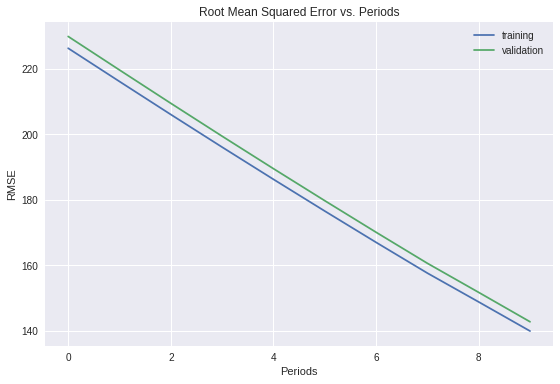

In [25]:
_ = train_model(
    learning_rate=0.01,
    steps=500,
    batch_size=5,
    training_examples=selected_training_examples,
    training_targets=training_targets,
    validation_examples=selected_validation_examples,
    validation_targets=validation_targets)

This is terrible. We still have not reached a minimum. Let's adjust some values: learning rate from 0.01 to 0.015 and steps from 500 to 1000.

Training model...
RMSE (on training data):
  period 00 : 205.99
  period 01 : 176.45
  period 02 : 148.45
  period 03 : 122.80
  period 04 : 101.78
  period 05 : 89.75
  period 06 : 85.79
  period 07 : 84.34
  period 08 : 84.19
  period 09 : 83.82
Model training finished.


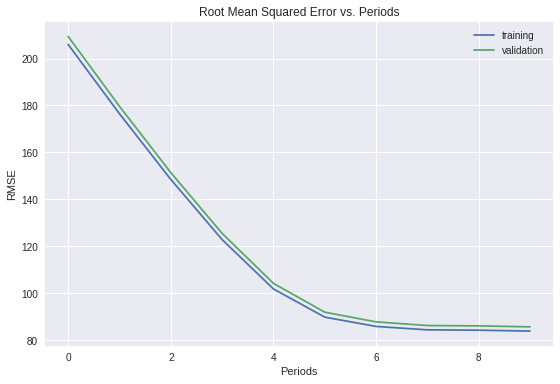

In [33]:
_ = train_model(
    learning_rate=0.015,
    steps=1000,
    batch_size=5,
    training_examples=selected_training_examples,
    training_targets=training_targets,
    validation_examples=selected_validation_examples,
    validation_targets=validation_targets)

This RMSE is significantly better for this model, but only represents about a 2% improvement over the earlier model. Lets try adding rooms per person to the model (along with latitude and median income) and see if the RMSE can be significantly improved.

Training model...
RMSE (on training data):
  period 00 : 118.43
  period 01 : 115.15
  period 02 : 113.13
  period 03 : 112.13
  period 04 : 109.44
  period 05 : 108.19
  period 06 : 107.91
  period 07 : 105.89
  period 08 : 107.48
  period 09 : 103.83
Model training finished.


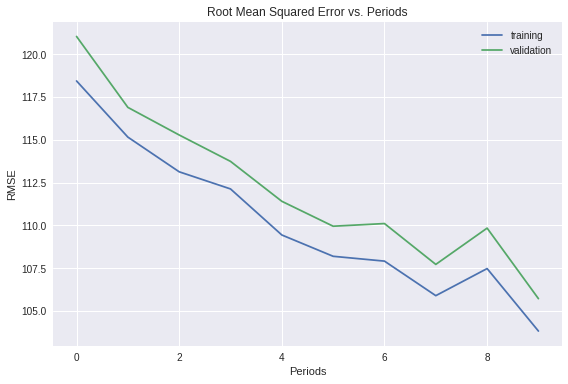

In [40]:
minimal_features = [
  "median_income",
  "latitude",
  "rooms_per_person"
]

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

LATITUDE_RANGES = zip(range(32, 44), range(33, 45))

def select_and_transform_features(source_df):
  selected_examples = pd.DataFrame()
  selected_examples["median_income"] = source_df["median_income"]
  for r in LATITUDE_RANGES:
    selected_examples["latitude_%d_to_%d" % r] = source_df["latitude"].apply(
      lambda l: 1.0 if l >= r[0] and l < r[1] else 0.0)
  return selected_examples

selected_training_examples = select_and_transform_features(training_examples)
selected_validation_examples = select_and_transform_features(validation_examples)

_ = train_model(
    learning_rate=0.015,
    steps=1000,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

There is still no minimum here. Let's adjust the learning rate to 0.025 and the steps to 2000.

Training model...
RMSE (on training data):
  period 00 : 112.23
  period 01 : 108.08
  period 02 : 103.83
  period 03 : 100.73
  period 04 : 96.28
  period 05 : 93.53
  period 06 : 91.05
  period 07 : 92.71
  period 08 : 88.98
  period 09 : 86.41
Model training finished.


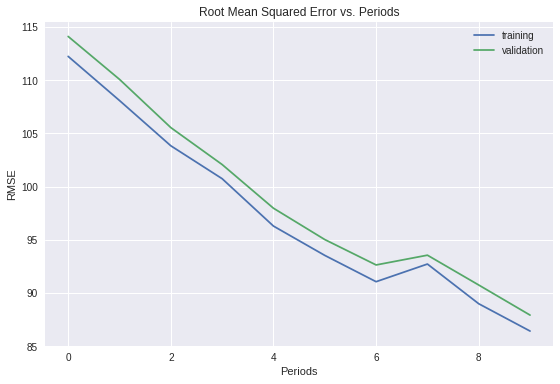

In [36]:
_ = train_model(
    learning_rate=0.025,
    steps=2000,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

The best RMSE achieved was 86.41 and there was still no minimum. Ok, I will adjust the learning rate to 0.03 and leave the steps at 2000.

Training model...
RMSE (on training data):
  period 00 : 111.85
  period 01 : 105.53
  period 02 : 101.30
  period 03 : 97.16
  period 04 : 93.40
  period 05 : 90.06
  period 06 : 90.36
  period 07 : 87.32
  period 08 : 85.82
  period 09 : 84.96
Model training finished.


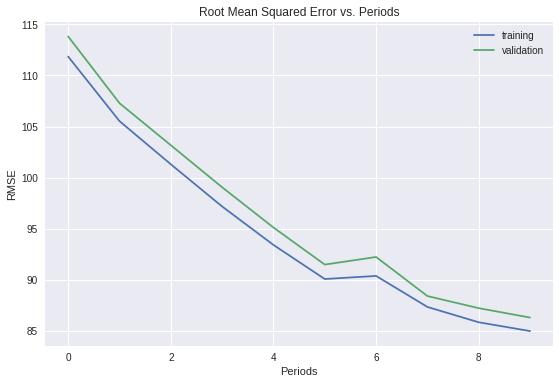

In [37]:
_ = train_model(
    learning_rate=0.03,
    steps=2000,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

Wow: still no minimum. I wonder if the learning rate has to be significantly increased when there are more features in the model. Well, I will bump up the learning rate to 0.035.

Training model...
RMSE (on training data):
  period 00 : 111.40
  period 01 : 104.08
  period 02 : 98.53
  period 03 : 96.96
  period 04 : 98.94
  period 05 : 89.37
  period 06 : 87.65
  period 07 : 85.58
  period 08 : 84.64
  period 09 : 84.44
Model training finished.


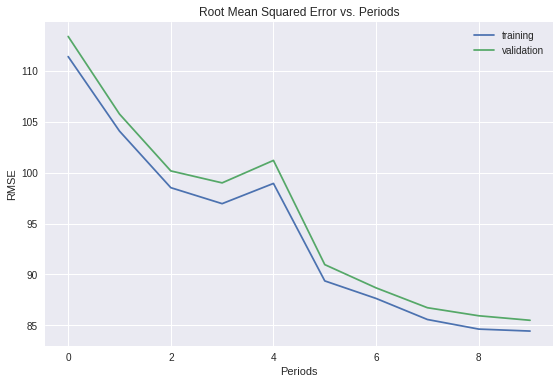

In [38]:
_ = train_model(
    learning_rate=0.035,
    steps=2000,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

This does not appear to be making a significant improvement (although we may be seeing a minimum). Let me go to 3000 steps.

Training model...
RMSE (on training data):
  period 00 : 106.74
  period 01 : 100.34
  period 02 : 91.94
  period 03 : 88.09
  period 04 : 88.14
  period 05 : 84.78
  period 06 : 84.31
  period 07 : 83.66
  period 08 : 84.89
  period 09 : 83.58
Model training finished.


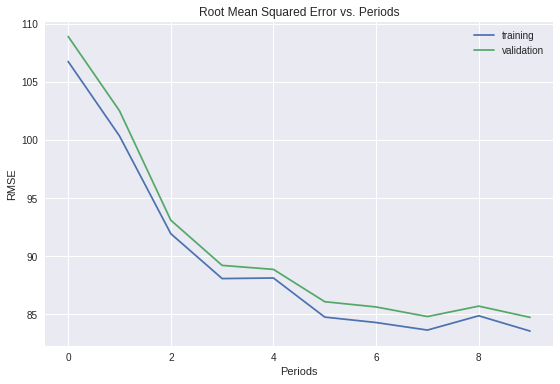

In [39]:
_ = train_model(
    learning_rate=0.035,
    steps=3000,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

The best RMSE for this model was 83.58. However, this model is more complex than the earlier model which achieved an RMSE of 85.53. According to Occam's Principle for ML, the simpler model is better. 

# HANDLING LATITUDE WITH ANOTHER METHOD

Ok, here is where I am going to try to use the logic I developed above to specify very precise ranges for San Francisco and L.A..

In [0]:
minimal_features = [
  "median_income",
  "latitude",
  "rooms_per_person"
]

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

def select_and_transform_features(source_df):
  BOOL=[]
  
  selected_examples = pd.DataFrame()
  selected_examples["median_income"] = source_df["median_income"]
  selected_examples["latitude"] = source_df["latitude"]
  return selected_examples
"""  for i in range(0,len(selected_examples['latitude']),1):
    if (((37 <= selected_examples["latitude[i]"])
        and (38.5>=selected_examples["latitude[i]"])) 
        or ((33.5<=selected_examples["latitude[i]"]) 
        and (34.5>=selected_examples["latitude[i]"]))):
      BOOL.append(1)
    else:
      BOOL.append(0)
  
  selected_examples['latitude'] = list(zip(source_df["latitude"]),BOOL)
  print(selected_examples.head())"""


selected_training_examples = select_and_transform_features(training_examples)
selected_validation_examples = select_and_transform_features(validation_examples)

Okay, I am still having trouble getting this to work, but I have to move on for now. This is where I should pick this up.
I am trying to create either a list or a dict which has the latitude in the first position and a Boolean value in the second position if it meets specific criteria. 

In [0]:
# PRACTICE_5: Add the criteria for a house in the San Francisco area
#LAT = [32,35,39,34,38.5,33,36,33.5,37,34.5,31,38]
#LAT.sort()
#print(LAT)
BOOL = []
#print("Length of LAT: ", len(LAT))
for i in range(0,len(LAT),1):
  if ((37 <= LAT[i]) and (38.5>=LAT[i]) or ((33.5<=LAT[i]) and (34.5>=LAT[i]))):
    BOOL.append(1)
  else:
    BOOL.append(0)

fancy = list(zip(LAT,BOOL))
"""for i in range(0, len(fancy),1):
  if(BOOL[i]==1):  
    print(fancy[i])"""
list(fancy)

In [0]:
_ = train_model(
    learning_rate=0.015,
    steps=1000,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)